In [2]:
import json
import os
from pathlib import Path
import sys
sys.path.append('..')
from mlm_utils.transform_func import encode_text


/home/phatpham/anaconda3/envs/min_ds-env/lib/python3.8/site-packages/torch/cuda/__init__.py:546: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
2024-05-22 13:10:19.130887: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-22 13:10:21.148604: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-22 13:10:23.664037: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-05-22 13:10:31.662073: E tensorflow/compiler/xla/stream_executor/cuda/cu

### load finetuned model

In [3]:
import torch
import sys
sys.path.append('..')
from utils.data_utils import NLP_MODELS
from SRL.model import multiTaskModel
model_file = Path('/mnt/c/Users/Phat Pham/Documents/THESIS/SRLPredictionEasel/output/multi_task_model_9_13050.pt')


def load_params(model_file):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    # Load finetuned model 
    loadedDict = torch.load(model_file, map_location=torch.device(device))
    
    taskParams = loadedDict['task_params']
    allParams = {}
    allParams['task_params'] = taskParams
    allParams['gpu'] = torch.cuda.is_available()
    
    # dummy values
    allParams['num_train_steps'] = 10
    allParams['warmup_steps'] = 0
    allParams['learning_rate'] = 2e-5
    allParams['epsilon'] = 1e-8

    modelName = taskParams.modelType.name.lower()
    print("Model Name: ", modelName)
    _, _ , tokenizerClass, defaultName = NLP_MODELS[modelName]
    configName = taskParams.modelConfig
    if configName is None:
        configName = defaultName

    tokenizer = tokenizerClass.from_pretrained(configName)
    
    return allParams, loadedDict, tokenizer

a = load_params(model_file)
model = multiTaskModel(a[0])
model.load_multi_task_model(a[1])

Model Name:  bert


In [4]:
def convert_save_json(data, wriDir, write_file):
    def encode_sentence(sentence):
        encode_data = encode_text(sentence['avg_neg_cos'])
        feature = {'origin_uid': sentence['origin_uid'], 
                    'input_ids': encode_data['input_ids'][0].tolist(),
                    'token_type_ids': encode_data['token_type_ids'][0].tolist(),
                    'attention_mask': encode_data['attention_mask'][0].tolist(),
                    'pos_tag_id': sentence['pos_tag_id']
                    }
        return feature
    features = list(map(encode_sentence, data))
    
    with open(os.path.join(wriDir, write_file) , 'w') as f:
        for item in features:
            f.write('{}\n'.format(json.dumps(item)))

In [5]:
# read masked_data_text

dataMaskedDir = Path('/mnt/c/Users/Phat Pham/Documents/THESIS/SRLPredictionEasel/MLM/data_mlm/pertured_data/masked_data_text')
with open(os.path.join(dataMaskedDir,'decrease_2_full.json'), 'r') as f:
    data =[json.loads(line) for line in f]
    


In [5]:
convert_save_json(data, dataMaskedDir, 'avg_neg_cos_decrease_2.json')

### get data mask


In [49]:

import numpy as np
import sys
sys.path.append('../')
from data_preparation import * 
from mlm_utils.pertured_dataset import PerturedDataset
import torch.nn as nn
import math
import os
import torch

class DataMaker():
    def __init__(self, data_file, out_dir, eval_batch_size=32, max_seq_len=85, seed=42):
        self.data_file = data_file
        self.out_dir = out_dir
        self.eval_batch_size = eval_batch_size
        self.max_seq_len = max_seq_len
        self.seed = seed
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        assert os.path.exists(self.data_file), "prediction tsv file not present at {}".format(self.data_file)
        
        self.dataset = PerturedDataset(self.data_file, self.device)
        self.dataloader = self.dataset.generate_batches(self.dataset, self.eval_batch_size)
       
    def get_predictions(self, model, is_masked=False):
        model.network.eval()
        
        allPreds = []
        allScores = []
        allLogitsSoftmax = []
        allLogitsRaw = []
        allLabels = []
        allOriginUIDs = []
        for batch in tqdm(self.dataloader, total = len(self.dataloader)):
            batch = tuple(t.to(self.device) if isinstance(t, torch.Tensor) else t for t in batch)

            if is_masked: 
                origin_uid, token_id, mask, type_id, pos_tag_id = batch
                # create a dummy label tensor
                label = torch.zeros(token_id.size(0), token_id.size(1), dtype=torch.long).to(self.device)
            else: 
                origin_uid, label, token_id, type_id, mask = batch 
            
            with torch.no_grad():
                _, logits = model.network(token_id, type_id, mask, 0, 'conllsrl')

               
                outLogitsSoftmax = nn.functional.softmax(logits, dim = 2).data.cpu().numpy()
                
                outLogitsSigmoid = nn.functional.sigmoid(logits).data.cpu().numpy()
                
                predicted_sm = np.argmax(outLogitsSoftmax, axis = 2)
                

                # here in score, we only want to give out the score of the class of tag, which is maximum
                predScore = np.max(outLogitsSigmoid, axis = 2).tolist() 
                
                predicted_sm = predicted_sm.tolist()
                
                # get the attention masks, we need to discard the predictions made for extra padding
                
                predictedTags = []
                predScoreTags = []
                
                if mask is not None:
                    #shape of attention Masks (batchSize, maxSeqLen)
                    actualLengths = mask.cpu().numpy().sum(axis = 1).tolist()
                
                    for i, (pred, sc) in enumerate(zip(predicted_sm, predScore)):
                        predictedTags.append( pred[:actualLengths[i]] )
                        predScoreTags.append( sc[:actualLengths[i]])
        
                else:
                    predictedTags = predicted_sm
                    predScoreTags = predScore
                
                allPreds.append(predictedTags)  
                allScores.append(predScoreTags)  
                allLogitsSoftmax.append(outLogitsSoftmax)
                allLabels.append(label.tolist())
                allLogitsRaw.append(logits.data.cpu().numpy())
                allOriginUIDs.append(origin_uid)
            

        labMapRevN  = {0: 'B-A1',
                        1: 'I-A1',
                        2: 'O',
                        3: 'B-V',
                        4: 'B-A0',
                        5: 'I-A0',
                        6: 'B-A4',
                        7: 'I-A4',
                        8: 'I-A3',
                        9: 'B-A2',
                        10: 'I-A2',
                        11: 'B-A3',
                        12: '[CLS]',
                        13: '[SEP]',
                        14: 'X'}

        allOriginUIDs = [item for sublist in allOriginUIDs for item in sublist]
        allPreds = [item for sublist in allPreds for item in sublist]
        allScores = [item for sublist in allScores for item in sublist]
        allLogitsSoftmax = [item for sublist in allLogitsSoftmax for item in sublist]
        allLogitsRaw = [item for sublist in allLogitsRaw for item in sublist]
        allLabels = [item for sublist in allLabels for item in sublist]
        
        for j, (p, l) in enumerate(zip(allPreds, allLabels)):
            allLabels[j] = l[:len(p)]
            allPreds[j] = [labMapRevN[int(ele)] for ele in p]
            allLabels[j] = [labMapRevN[int(ele)] for ele in allLabels[j]]
        #allPreds[i] = [ [ labMapRev[int(p)] for p in pp ] for pp in allPreds[i] ]
        #allLabels[i] = [ [labMapRev[int(l)] for l in ll] for ll in allLabels[i] ]

        newPreds = []
        newLabels = []
        newScores = []
        newLogitsSoftmax = []
        for m, samp in enumerate(allLabels):
            Preds = []
            Labels = []
            Scores = []
            LogitsSm = []
            for n, ele in enumerate(samp):
                #print(ele)
                if ele != '[CLS]' and ele != '[SEP]' and ele != 'X':
                    #print('inside')
                    Preds.append(allPreds[m][n])
                    Labels.append(ele)
                    Scores.append(allScores[m][n])
                    LogitsSm.append(allLogitsSoftmax[m][n])
                    #del allLabels[i][m][n]
                    #del allPreds[i][m][n]
            newPreds.append(Preds)
            newLabels.append(Labels)
            newScores.append(Scores)
            newLogitsSoftmax.append(LogitsSm)
        allLabels = newLabels
        allPreds = newPreds
        allScores = newScores    
        allLogitsSoftmax = newLogitsSoftmax        
                
        # flatten allPreds, allScores
     
        return allOriginUIDs, allPreds, allScores, allLogitsSoftmax, allLogitsRaw, allLabels    

In [50]:
# import os
# from pathlib import Path
# from data_maker import DataMaker

dataMaker = DataMaker(
    data_file= os.path.join(dataMaskedDir,'avg_neg_cos_decrease_2.json'),
    out_dir= os.path.join(dataMaskedDir,'data_predictions')
)

resultwordMasked  = dataMaker.get_predictions(model, is_masked=True)
resultwordMasked = {
    'uid': resultwordMasked[0],
    'pred': resultwordMasked[1],
    'score': resultwordMasked[2],
    'logitsSoftmax': resultwordMasked[3],
    'logitsRaw': resultwordMasked[4],
    'dummy_label': resultwordMasked[5] 
}

100%|██████████| 17/17 [01:27<00:00,  5.14s/it]


In [8]:
labMap  = {0: 'B-A1',
            1: 'I-A1',
            2: 'O',
            3: 'B-V',
            4: 'B-A0',
            5: 'I-A0',
            6: 'B-A4',
            7: 'I-A4',
            8: 'I-A3',
            9: 'B-A2',
            10: 'I-A2',
            11: 'B-A3',
            12: '[CLS]',
            13: '[SEP]',
            14: 'X'}

In [9]:
labMap = {v: k for k, v in labMap.items()}
labMap

{'B-A1': 0,
 'I-A1': 1,
 'O': 2,
 'B-V': 3,
 'B-A0': 4,
 'I-A0': 5,
 'B-A4': 6,
 'I-A4': 7,
 'I-A3': 8,
 'B-A2': 9,
 'I-A2': 10,
 'B-A3': 11,
 '[CLS]': 12,
 '[SEP]': 13,
 'X': 14}

In [51]:
dataOriginDir = Path('/mnt/c/Users/Phat Pham/Documents/THESIS/SRLPredictionEasel/MLM/data_mlm/process_folder/coNLL_tsv_json/modify_label_prepared_data')
dataMaker = DataMaker(
    data_file= os.path.join(dataOriginDir,'ner_conll_format_decrease_2_full.json'),
    out_dir= os.path.join(dataOriginDir, 'data_predictions')
)

resultwordOrigin  = dataMaker.get_predictions(model, is_masked=False)
resultwordOrigin = {
    'uid': resultwordOrigin[0],
    'pred': resultwordOrigin[1],
    'score': resultwordOrigin[2],
    'logitsSoftmax': resultwordOrigin[3],
    'logitsRaw': resultwordOrigin[4],
    'label': resultwordOrigin[5]  
}


  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:09<00:00,  4.98s/it]


In [52]:
import numpy as np
import torch

def get_idx_arg_preds(preds_origin, preds_masked, label_origin=None): # label_origin: nhãn gold
    list_idx_arg_change = []
 
    # assert len(preds_origin) == len(preds_masked), 'Length of preds_origin and preds_masked must be the same'
    # for i in range(len(preds_origin) if len(preds_origin) < len(preds_masked) else len(preds_masked)):
    #     test = preds_origin[i] not in [2, 3, 12, 13, 14] or preds_masked[i] not in [2, 3, 12, 13, 14]
    #     if label_origin:
    #         # assert len(preds_origin) == len(label_origin), 'Length of preds_origin and label_origin must be the same'
    #         if test or label_origin[i] not in [2, 3, 12, 13, 14]:
    #             list_idx_arg_change.append(i)
    #     else:
    #         if test:
    #             list_idx_arg_change.append(i)
    for i in range(len(preds_origin) if len(preds_origin) < len(preds_masked) else len(preds_masked)):
        test = preds_origin[i].startswith('B-A') or preds_origin[i].startswith('I-A') or preds_masked[i].startswith('B-A') or preds_masked[i].startswith('I-A')
        if label_origin:
            assert len(preds_origin) == len(label_origin), 'Length of preds_origin and label_origin must be the same'
            if test or label_origin[i].startswith('B-A') or label_origin[i].startswith('I-A'):
                list_idx_arg_change.append(i)
        else:
            if test:
                list_idx_arg_change.append(i)
   
    return list_idx_arg_change

def calculateInfluenceScore(outLogitsSigmoid_original, outLogitsSigmoid_meddle, list_arg_change):
    influence_score = []
    weight = []
    # assert len(outLogitsSigmoid_original) == len(outLogitsSigmoid_meddle) 
    for i in range(len(outLogitsSigmoid_original) if len(outLogitsSigmoid_original) < len(outLogitsSigmoid_meddle) else len(outLogitsSigmoid_meddle)):
        if i not in list_arg_change:
            continue
        max_index_original = np.argmax(outLogitsSigmoid_original[i])
        max_index_meddle = np.argmax(outLogitsSigmoid_meddle[i])
        if max_index_original == max_index_meddle:
            influence_score.append((outLogitsSigmoid_original[i][max_index_original] - outLogitsSigmoid_meddle[i][max_index_meddle]) / max(outLogitsSigmoid_original[i][max_index_original], outLogitsSigmoid_meddle[i][max_index_meddle]))
            weight.append(1)
        else:
            influ_old_label = (outLogitsSigmoid_original[i][max_index_original] - outLogitsSigmoid_meddle[i][max_index_original]) / max(outLogitsSigmoid_original[i][max_index_original], outLogitsSigmoid_meddle[i][max_index_original])
            influ_new_label = (outLogitsSigmoid_meddle[i][max_index_meddle] - outLogitsSigmoid_original[i][max_index_meddle]) / max(outLogitsSigmoid_original[i][max_index_meddle], outLogitsSigmoid_meddle[i][max_index_meddle])
            influence_score.append(influ_old_label + influ_new_label)
            weight.append(2)
    return influence_score, weight

In [53]:
print(resultwordMasked['uid'][11], resultwordOrigin['uid'][17])

tensor(17) 17


In [ ]:
# from sklearn.metrics import f1_score
# y_true = [item for sublist in resultwordOrigin['label'] for item in sublist]
# y_pred = [item for sublist in resultwordOrigin['pred'] for item in sublist]
# result_f1 = f1_score(y_true, y_pred, average='micro') 
# result_f1

In [54]:
import torch
# for i in range(len(resultwordOrigin['logitsSoftmax'])):
#     resultwordOrigin['logitsSoftmax'][i] = torch.tensor(resultwordOrigin['logitsSoftmax'][i])
# for i in range(len(resultwordMasked['logitsSoftmax'])):
#     resultwordMasked['logitsSoftmax'][i] = torch.tensor(resultwordMasked['logitsSoftmax'][i])
    
influenceScore, weight = calculateInfluenceScore(resultwordOrigin['logitsSoftmax'][17], resultwordMasked['logitsSoftmax'][11], get_idx_arg_preds(resultwordOrigin['pred'][17], resultwordMasked['pred'][11]))

In [55]:
influenceScore

[1.9996338, 1.9999962, 1.9998764, 1.9996617, 1.9985108, 1.9993356, 1.9817008]

In [56]:
print(sum(influenceScore) / sum(weight))

0.9984796643257141


In [57]:
import numpy as np


def relevance_score(prob_origin_, prob_masked_, label_gold, label_origin, label_masked):
    relevance = []
    weight = []
    jud_space = get_idx_arg_preds(label_origin, label_masked, label_gold)
    for i in range(len(prob_origin_)):
        if i not in jud_space:
            continue
        # print(i)
        max_index_origin = np.argmax(prob_origin_[i])
        max_index_masked = np.argmax(prob_masked_[i])
        idx_label_gold = labMap[str(label_gold[i])]
        # idx_label_gold = label_gold[i]
        if label_gold[i] == label_origin[i] and label_gold[i] == label_masked[i]:
            score_increase_gold = (prob_origin_[i][idx_label_gold] - prob_masked_[i][idx_label_gold])/max(prob_origin_[i][idx_label_gold], prob_masked_[i][idx_label_gold])
            relevance.append(score_increase_gold)
            weight.append(1)
            # print(score_increase_gold)
        elif label_gold[i] != label_origin[i] and label_origin[i] == label_masked[i]:
            score_increase_gold = (prob_origin_[i][idx_label_gold] - prob_masked_[i][idx_label_gold])/max(prob_origin_[i][idx_label_gold], prob_masked_[i][idx_label_gold])
            score_decrease_mask = (prob_masked_[i][max_index_masked] - prob_origin_[i][max_index_masked])/max(prob_masked_[i][max_index_masked], prob_origin_[i][max_index_masked])
            relevance.append((score_increase_gold + score_decrease_mask)/2)
            weight.append(2)
            # print(score_increase_gold, score_decrease_mask)
        elif label_origin[i] != label_masked[i] and label_masked[i] == label_gold[i]:
            score_increase_gold = (prob_origin_[i][idx_label_gold] - prob_masked_[i][idx_label_gold])/max(prob_origin_[i][idx_label_gold], prob_masked_[i][idx_label_gold])
            score_decrease_origin = (prob_masked_[i][max_index_origin] - prob_origin_[i][max_index_origin])/max(prob_masked_[i][max_index_origin], prob_origin_[i][max_index_origin])
            relevance.append((score_increase_gold + score_decrease_origin)/2)
            weight.append(2)
            # print(score_increase_gold, score_decrease_origin)
        elif label_gold[i] != label_origin[i] and label_masked[i] != label_gold[i]:
            score_increase_gold = (prob_origin_[i][idx_label_gold] - prob_masked_[i][idx_label_gold])/max(prob_origin_[i][idx_label_gold], prob_masked_[i][idx_label_gold])
            score_decrease_mask = (prob_masked_[i][max_index_masked] - prob_origin_[i][max_index_masked])/max(prob_masked_[i][max_index_masked], prob_origin_[i][max_index_masked])
            score_decrease_origin = (prob_masked_[i][max_index_origin] - prob_origin_[i][max_index_origin])/max(prob_masked_[i][max_index_origin], prob_origin_[i][max_index_origin])
            relevance.append((score_increase_gold + score_decrease_mask + score_decrease_origin)/3)
            weight.append(1)
            # print(score_increase_gold, score_decrease_mask, score_decrease_origin)
        else:
            relevance.append(0)
        # print('------------------------')
    return relevance, weight

In [58]:
relevance_in_all_words, weights = relevance_score(resultwordOrigin['logitsSoftmax'][17], resultwordMasked['logitsSoftmax'][11], resultwordOrigin['label'][17], resultwordOrigin['pred'][17], resultwordMasked['pred'][11])

In [59]:
sum(relevance_in_all_words) / sum(weights)

-0.12205681062880015

In [60]:
print(resultwordOrigin['uid'][39], resultwordMasked['uid'][160])

39 tensor(39)


In [62]:
def competence_score(origin, masked):
    result = []
    jump_count = 0
    for i in range(len(origin['uid'])):
        for j in range(jump_count, len(masked['uid'])):
            if int(origin['uid'][i]) == int(masked['uid'][j]):
              
                influenceScore, weight_influ = calculateInfluenceScore(origin['logitsSoftmax'][i], masked['logitsSoftmax'][j], get_idx_arg_preds(origin['pred'][i], masked['pred'][j]))
                relevance_in_all_words, weight_relevance = relevance_score(origin['logitsSoftmax'][i], masked['logitsSoftmax'][j], origin['label'][i], origin['pred'][i], masked['pred'][j])
                result.append(
                    {
                        'uid': origin['uid'][i],
                        'influence': sum(influenceScore) / sum(weight_influ),
                        'relevance': sum(relevance_in_all_words) / sum(weight_relevance)
                    }
                )
            else:
                jump_count = j
                break
        
    return result

In [64]:
competence = competence_score(resultwordOrigin, resultwordMasked)
competence

[{'uid': '16',
  'influence': 0.9999330878257752,
  'relevance': -0.128052261347572},
 {'uid': '16',
  'influence': 0.9999307751655578,
  'relevance': -0.1250039697624743},
 {'uid': '16',
  'influence': 0.9989763796329498,
  'relevance': -0.07937623808781306},
 {'uid': '17',
  'influence': 0.9998826026916504,
  'relevance': -0.12168473502000172},
 {'uid': '17',
  'influence': 0.9999051451683044,
  'relevance': -0.09279269228378932},
 {'uid': '17',
  'influence': 0.9998684048652648,
  'relevance': -0.09362839162349701},
 {'uid': '17',
  'influence': 0.999855387210846,
  'relevance': -0.08213282376527786},
 {'uid': '17',
  'influence': 0.9999062538146972,
  'relevance': -0.13239741697907448},
 {'uid': '17',
  'influence': 0.9998020033041636,
  'relevance': -0.07983008523782094},
 {'uid': '17',
  'influence': 0.9998824954032898,
  'relevance': -0.11788054245213668},
 {'uid': '17',
  'influence': 0.9998807191848755,
  'relevance': -0.12020120987047751},
 {'uid': '17',
  'influence': 0.9984

In [65]:
from scipy.stats import spearmanr, permutation_test

influence_values = [item['influence'] for item in competence]
relevance_values = [item['relevance'] for item in competence]

# Calculate Spearman correlation coefficient
correlation_coefficient, p_value = spearmanr(influence_values, relevance_values)


print("Spearman correlation coefficient:", correlation_coefficient)
print("p-value:", p_value) # 0.0000517314356670977

Spearman correlation coefficient: -0.6925682270104242
p-value: 2.4822135336979626e-34


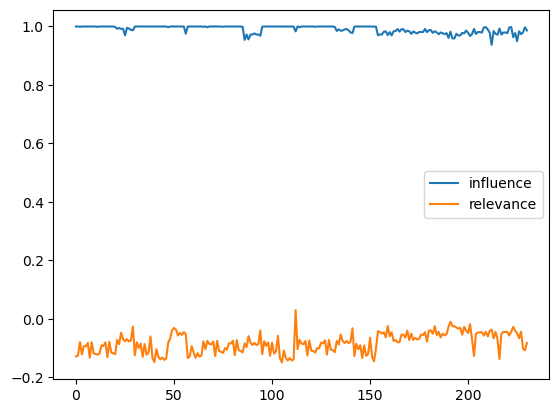

In [66]:
# visualize the influence and relevance score
import matplotlib.pyplot as plt


influence = [item['influence'] for item in competence]
relevance = [item['relevance'] for item in competence]

# line chart
plt.plot(influence, label='influence')
plt.plot(relevance, label='relevance')
plt.legend()
plt.show()